In [19]:
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import quandl
import numpy as np
import seaborn as sns
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
np.random.seed(7)

df = quandl.get('WIKI/TSLA')
print(df.head())

             Open     High    Low  Close      Volume  Ex-Dividend  \
Date                                                                
2010-06-29  19.00  25.0000  17.54  23.89  18766300.0          0.0   
2010-06-30  25.79  30.4192  23.30  23.83  17187100.0          0.0   
2010-07-01  25.00  25.9200  20.27  21.96   8218800.0          0.0   
2010-07-02  23.00  23.1000  18.71  19.20   5139800.0          0.0   
2010-07-06  20.00  20.0000  15.83  16.11   6866900.0          0.0   

            Split Ratio  Adj. Open  Adj. High  Adj. Low  Adj. Close  \
Date                                                                  
2010-06-29          1.0      19.00    25.0000     17.54       23.89   
2010-06-30          1.0      25.79    30.4192     23.30       23.83   
2010-07-01          1.0      25.00    25.9200     20.27       21.96   
2010-07-02          1.0      23.00    23.1000     18.71       19.20   
2010-07-06          1.0      20.00    20.0000     15.83       16.11   

            Adj. V

In [20]:
df.to_csv('tesla.csv')

df = pd.read_csv('tesla.csv',parse_dates=True,index_col='Date')


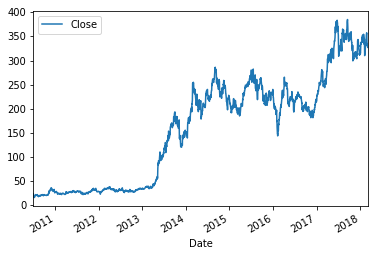

In [21]:
#plotting Closing Balance
df[['Close']].plot()
plt.show()

n_df = df[['Close']]

In [23]:
#Scaling the data as RNN are very sensitive to scale 

scaler = MinMaxScaler(feature_range = (0,1))
n_df = scaler.fit_transform(n_df)


In [24]:
#Spliting the data (70:30)
training_size = int(len(n_df)*.70)
test_size = len(n_df) - training_size

train = n_df[0:training_size,:]
test = n_df[training_size:len(n_df),:]

In [27]:
# convert an array of values into a dataset matrix
#This default will create a dataset where X is the price of share at a given time (t) and Y is the price of share at the next time (t + 1).
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [28]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [31]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/100
 - 3s - loss: 0.0251
Epoch 2/100
 - 2s - loss: 1.8189e-04
Epoch 3/100
 - 2s - loss: 1.6683e-04
Epoch 4/100
 - 2s - loss: 1.6256e-04
Epoch 5/100
 - 2s - loss: 1.6051e-04
Epoch 6/100
 - 2s - loss: 1.5523e-04
Epoch 7/100
 - 2s - loss: 1.5207e-04
Epoch 8/100
 - 2s - loss: 1.5439e-04
Epoch 9/100
 - 2s - loss: 1.5151e-04
Epoch 10/100
 - 2s - loss: 1.4781e-04
Epoch 11/100
 - 2s - loss: 1.5363e-04
Epoch 12/100
 - 2s - loss: 1.5259e-04
Epoch 13/100
 - 2s - loss: 1.4846e-04
Epoch 14/100
 - 2s - loss: 1.5060e-04
Epoch 15/100
 - 2s - loss: 1.5175e-04
Epoch 16/100
 - 2s - loss: 1.5438e-04
Epoch 17/100
 - 2s - loss: 1.5602e-04
Epoch 18/100
 - 2s - loss: 1.4773e-04
Epoch 19/100
 - 3s - loss: 1.4740e-04
Epoch 20/100
 - 2s - loss: 1.4875e-04
Epoch 21/100
 - 2s - loss: 1.5423e-04
Epoch 22/100
 - 2s - loss: 1.5250e-04
Epoch 23/100
 - 3s - loss: 1.51

In [50]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(np.transpose(trainY))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(np.transpose(testY))


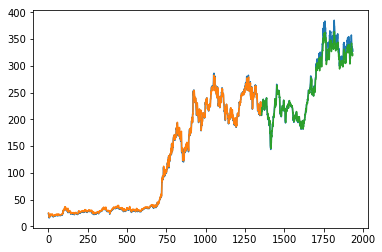

In [51]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(n_df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(n_df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(n_df)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(n_df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()